In [1]:
import torchvision.transforms as tf
import torchvision.transforms.functional as TF
import sys
sys.path.append("../")
import gc
import numpy as np
import scanpy as sc
import squidpy as sq
import tqdm
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
from Models.DeepPT import augment as aug_
from Dataloader.Dataset import *
        

Dataset path: /afm01/UQ/Q2051


In [2]:
# Color normalization
target = cv2.cvtColor(cv2.imread(f"../Dataset/Reference_Normalization/ref_HE.png"), cv2.COLOR_BGR2RGB)
def color_normalization(img, target, method="macenko"):
    """
    img: numpy array, RGB image
    method: str, "raw", "macenko" or "reinhard"
    target: numpy array, RGB image
    """

    T = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(224),
        transforms.Lambda(lambda x: x*255)
    ])
    if method == "macenko":
        Normalizer = torchstain.normalizers.MacenkoNormalizer(backend='torch')
        Normalizer.fit(T(target))
        img, Macenko_H, Macenko_E = Normalizer.normalize(I=T(img), stains=True)
    elif method == "reinhard":
        Normalizer = torchstain.normalizers.ReinhardNormalizer(backend='torch')
        Normalizer.fit(T(target))
        img = Normalizer.normalize(I=T(img))
    elif method == "raw":
        img = img
    return img

def aug(image, trans):
    # Randomly select one augmentation
    selected_augmentation = trans

    # Apply the selected augmentation
    if selected_augmentation == "blur":
        # Gassian blur
        image = tf.GaussianBlur(kernel_size=7, sigma=(1, 1.5))(image)

    elif selected_augmentation == "random_grayscale":
        # Random grayscale
        image = tf.RandomGrayscale(1.0)(image)
        
    elif selected_augmentation == "random_rotation":
        # Random flipping and rotations
        if random.random() > 0.5:
            image = TF.hflip(image)
        if random.random() > 0.5:
            image = TF.vflip(image)
        if random.random() > 0.5:
            image = TF.rotate(image, random.choice([180, 90, 0, -90]))
    elif selected_augmentation == "reinhard":
        # Color normalization
        image = torch.tensor(color_normalization(image.permute(1,2,0).numpy(), target, method="reinhard")).permute(2,0,1)

    elif selected_augmentation == "none":
        # No augmentation
        pass
    return image

In [3]:
dataset_name = "Skin_cSCC"
target_gene_list = np.load(f"../Dataset/Gene_list/Gene_list_func_{dataset_name}.npy", allow_pickle=True)
te_data = CSCC(train=False, fold=1, r=112, num_subsets=1,
                            neighs=4, color_norm="raw", exp_norm="log1p",
                            gene_list=target_gene_list)

['P2_ST_rep2']
Loading imgs...


100%|██████████| 1/1 [00:03<00:00,  3.28s/it]


Loading metadata...


100%|██████████| 1/1 [00:11<00:00, 11.81s/it]


subset_size: 646
Loading gene expression
Croping WSI into patches...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


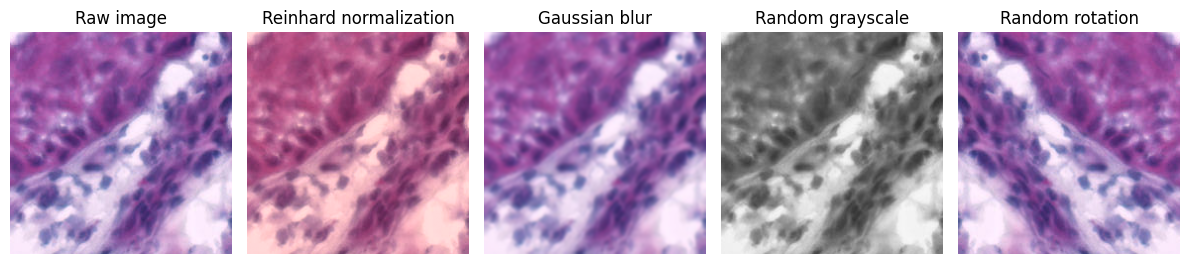

In [9]:
import matplotlib.pyplot as plt
import numpy as np

img = te_data[0][0][15]
trans = ["none", "reinhard", "blur", "random_grayscale", "random_rotation" ]

# Create a 1x4 subplot grid
fig, axes = plt.subplots(1, 5, figsize=(12, 6))

# Iterate over transformations
for i, tran in enumerate(trans):
    aug_img = aug(img, tran).cpu().numpy()

    if len(aug_img.shape) == 4:
        aug_img = aug_img.squeeze(0).transpose(1, 2, 0) / 255
    else:
        aug_img = aug_img.transpose(1, 2, 0) / 255.0
    
    if tran == "blur":
        tran = "Gaussian blur"
    elif tran == "random_grayscale":
        tran = "Random grayscale"
    elif tran == "random_rotation":
        tran = "Random rotation"
    elif tran == "reinhard":
        tran = "Reinhard normalization"
    elif tran == "template":
        tran = "Template"
    elif tran == "none":
        tran = "Raw image"

    # Plot each augmented image
    axes[i].imshow(aug_img)
    axes[i].set_title(tran)
    axes[i].axis('off')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])  # rect parameter to leave space for the common title

# Show the plot
plt.show()


# Visual gene expression

In [1]:
import sys
sys.path.append("../")
from Dataloader.Dataset import *
import gc
import numpy as np
import scanpy as sc
import squidpy as sq
import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scprep as scp


Dataset path: /afm01/UQ/Q2051


In [2]:
adatas = []
target_gene_list = np.load(f"../Dataset/Gene_list/Gene_list_func_Skin_cSCC.npy", allow_pickle=True)
for i in range(1):
    gc.collect()
    te_data = CSCC(train=False, fold=i, r=112, num_subsets=1,
                    neighs=4, color_norm="raw", exp_norm="raw",
                    gene_list=target_gene_list)
    adata_dict = te_data.meta_dict
    adatas.append(adata_dict[list(adata_dict.keys())[0]])

['P2_ST_rep1']
Loading imgs...


100%|██████████| 1/1 [00:03<00:00,  3.28s/it]


Loading metadata...


100%|██████████| 1/1 [00:14<00:00, 14.52s/it]


subset_size: 666
Loading gene expression
Croping WSI into patches...


In [3]:
# Concatenate all adata
adata_cat = ad.concat(adatas).copy()

# Convert adata to df
exp = adata_cat.to_df()
exp

,MIR1302-2,RP11-34P13.7,RP11-34P13.14,FO538757.1,RP4-669L17.10,RP11-206L10.9,LINC00115,RP11-54O7.1,SAMD11,NOC2L,...,DAZ2,AC012005.2,AC012005.1,BPY2B,DAZ3,DAZ4,BPY2C,AC006386.1,LINC00266-4P,AC006328.1
34x42,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
21x21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
23x21,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
16x24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
26x18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20x12,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39x27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20x48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
39x45,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0


In [13]:
# Gene expression preprocessing
def expression_normalization(exp, exp_norm, target_gene_list):
    print("length of target genes:", len(target_gene_list))
    if exp_norm == "raw":
        exp_new = exp[target_gene_list].values.astype(np.float64) 
    elif exp_norm == "lognorm":
        exp_new = scp.transform.log(scp.normalize.library_size_normalize(exp[target_gene_list].values)).astype(np.float64)
    elif exp_norm == "norm":
        exp_new = scp.normalize.library_size_normalize(exp[target_gene_list].values).astype(np.float64)
    elif exp_norm == "log1p":
        exp_new = scp.transform.log(exp[target_gene_list].values).astype(np.float64)
    elif exp_norm == "minmax":
        exp_new = MinMaxScaler().fit_transform(exp[target_gene_list].values).astype(np.float64)
    exp_new = sc.AnnData(exp_new)
    exp_new.var_names = target_gene_list
    return exp_new


In [14]:
exp[target_gene_list].columns.get_loc("PFN1")


834

## Current visualization

In [45]:
# Functional genes
target_gene_list = np.load(f"../Dataset/Gene_list/Gene_list_func_Skin_cSCC.npy", allow_pickle=True)

# Gene expression preprocessing
exp_raw = expression_normalization(exp, "raw", target_gene_list)
exp_norm = expression_normalization(exp, "norm", target_gene_list)
exp_log = expression_normalization(exp, "log1p", target_gene_list)
exp_lognorm = expression_normalization(exp, "lognorm", target_gene_list)
exp_minmax = expression_normalization(exp, "minmax", target_gene_list)

# Convert the numpy array to dataframe
x = pd.DataFrame({"Raw": exp_raw.to_df().iloc[:,834]})
x["Norm"] = exp_norm.to_df().iloc[:,834]
x["Log1p"] = exp_log.to_df().iloc[:,834]
x["LogNorm"] = exp_lognorm.to_df().iloc[:,834]
x["MinMax"] = exp_minmax.to_df().iloc[:,834]
x


length of target genes: 1318
length of target genes: 1318
length of target genes: 1318
length of target genes: 1318
length of target genes: 1318


,Raw,Norm,Log1p,LogNorm,MinMax
0,2.0,104.166667,0.477121,2.021878,0.010471
1,6.0,114.722753,0.845098,2.063419,0.031414
2,26.0,200.462606,1.431364,2.304194,0.136126
3,16.0,99.440646,1.230449,2.001909,0.083770
4,2.0,157.480315,0.477121,2.199975,0.010471
...,...,...,...,...,...
661,8.0,201.005025,0.954243,2.305362,0.041885
662,108.0,254.837187,2.037426,2.407964,0.565445
663,93.0,268.011527,1.973128,2.429771,0.486911
664,3.0,178.571429,0.602060,2.254237,0.015707


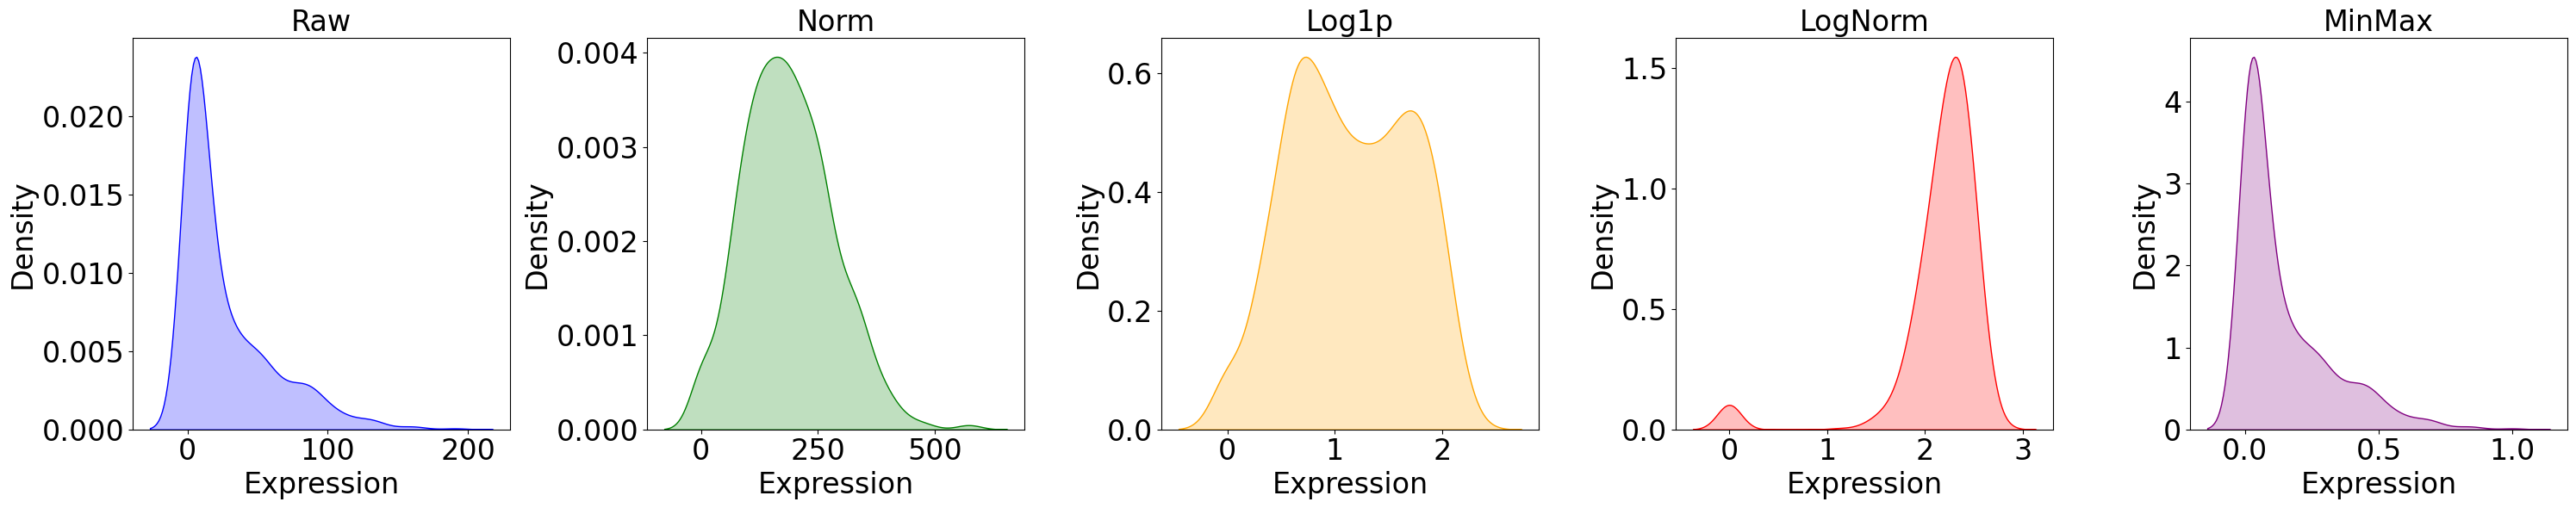

In [46]:
import seaborn as sns

# Create a 1x5 subplot grid with a larger overall figure size
fig, axes = plt.subplots(1, 5, figsize=(30, 6))

# List of methods and corresponding colors
methods = ['Raw', 'Norm', 'Log1p', 'LogNorm', 'MinMax']
colors = ['blue', 'green', 'orange', 'red', 'purple']

# Iterate over methods
for i, method in enumerate(methods):
    # Specify color for each method
    sns.kdeplot(data=x[method], common_norm=False, fill=True, ax=axes[i], color=colors[i])

    # Set titles and labels
    axes[i].set_title(method, fontsize=24)
    axes[i].set_xlabel('Expression', fontsize=24)
    axes[i].set_ylabel('Density', fontsize=24)

    # Customize tick labels
    axes[i].tick_params(axis='both', which='both', labelsize=24)

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()
